In [13]:
import pandas as pd


# read the CSV file
docker_stats = pd.read_csv('jaeger-docker-stats-v4.csv')

# remove duplicate headers
docker_stats = docker_stats[docker_stats['timestamp'] != 'timestamp']



# convert the values to use the correct data type automatically,except timestamp
docker_stats = docker_stats.apply(pd.to_numeric, errors='ignore')

#2024-12-10T09:30:12.820Z
docker_stats['timestamp'] = pd.to_datetime(docker_stats['timestamp'], format='%Y-%m-%dT%H:%M:%S.%fZ')


# map index: Jaeger: JAEGER, TelemetryNpm: OAS_TLM, "": "NO_TLM"
docker_stats['index'] = docker_stats['index'].map({'Jaeger': 'JAEGER', 'Telemetry': 'OAS_TLM', '': 'NO_TLM'}).fillna("NO_TLM")
docker_stats.tail()

,timestamp,containerName,testname,repeatTestCount,index,orderOfMagnitude.name,orderOfMagnitude.value,orderOfMagnitude.estimatedResponseTime,orderOfMagnitude.secureResponseTime,baseURL,concurrentUsers,currentIteration,telemetryStatus,cpu_stats.cpu_usage.total_usage,cpu_stats.cpu_usage.usage_in_kernelmode,cpu_stats.cpu_usage.usage_in_usermode,cpu_stats.system_cpu_usage,cpu_stats.online_cpus,cpu_stats.throttling_data.periods,cpu_stats.throttling_data.throttled_periods,cpu_stats.throttling_data.throttled_time,memory_stats.usage,memory_stats.max_usage,memory_stats.stats.active_anon,memory_stats.stats.active_file,memory_stats.stats.cache,memory_stats.stats.dirty,memory_stats.stats.hierarchical_memory_limit,memory_stats.stats.hierarchical_memsw_limit,memory_stats.stats.inactive_anon,memory_stats.stats.inactive_file,memory_stats.stats.mapped_file,memory_stats.stats.pgfault,memory_stats.stats.pgmajfault,memory_stats.stats.pgpgin,memory_stats.stats.pgpgout,memory_stats.stats.rss,memory_stats.stats.rss_huge,memory_stats.stats.total_active_anon,memory_stats.stats.total_active_file,memory_stats.stats.total_cache,memory_stats.stats.total_dirty,memory_stats.stats.total_inactive_anon,memory_stats.stats.total_inactive_file,memory_stats.stats.total_mapped_file,memory_stats.stats.total_pgfault,memory_stats.stats.total_pgmajfault,memory_stats.stats.total_pgpgin,memory_stats.stats.total_pgpgout,memory_stats.stats.total_rss,memory_stats.stats.total_rss_huge,memory_stats.stats.total_unevictable,memory_stats.stats.total_writeback,memory_stats.stats.unevictable,memory_stats.stats.writeback,memory_stats.limit,precpu_stats.cpu_usage.total_usage,precpu_stats.cpu_usage.usage_in_kernelmode,precpu_stats.cpu_usage.usage_in_usermode,precpu_stats.throttling_data.periods,precpu_stats.throttling_data.throttled_periods,precpu_stats.throttling_data.throttled_time,precpu_stats.system_cpu_usage,precpu_stats.online_cpus
1458,2024-12-21 21:07:52.409,jaeger,Jaeger Comparison,3,JAEGER,large,88000,100,200,http://localhost:8080,1,3,UNKNOWN,322105100,40000000,290000000,1439344400000000,16,0,0,0,74088448,74522624,4096,0,0,0,2147483648,2147483648,72921088,0,0,6806,0,5461,942,72929280,54525952,4096,0,0,0,72921088,0,0,6806,0,5461,942,72929280,54525952,0,0,0,0,2147483648,319867500,40000000,290000000,1439328420000000,16,0,0,0
1459,2024-12-21 21:07:53.412,oastlm-test-ks-api,Jaeger Comparison,3,JAEGER,large,88000,100,200,http://localhost:8080,1,3,UNKNOWN,40065763100,2980000000,37530000000,1439360510000000,16,0,0,0,102522880,186421248,4096,28672,32768,0,2147483648,2147483648,95469568,4096,0,1051557,0,1050478,1027667,95494144,2097152,4096,28672,32768,0,95469568,4096,0,1051557,0,1050478,1027667,95494144,2097152,0,0,0,0,2147483648,39017261200,2920000000,36450000000,1439344380000000,16,0,0,0
1460,2024-12-21 21:07:53.413,jaeger,Jaeger Comparison,3,JAEGER,large,88000,100,200,http://localhost:8080,1,3,UNKNOWN,324905200,40000000,290000000,1439360600000000,16,0,0,0,74092544,74522624,4096,0,0,0,2147483648,2147483648,72921088,0,0,6807,0,5462,942,72933376,54525952,4096,0,0,0,72921088,0,0,6807,0,5462,942,72933376,54525952,0,0,0,0,2147483648,322105100,40000000,290000000,1439344400000000,16,0,0,0
1461,2024-12-21 21:07:54.415,oastlm-test-ks-api,Jaeger Comparison,3,JAEGER,large,88000,100,200,http://localhost:8080,1,3,UNKNOWN,41118842800,3030000000,38550000000,1439376650000000,16,0,0,0,143011840,186421248,4096,28672,32768,0,2147483648,2147483648,134705152,4096,0,1087183,0,1086104,1053685,134823936,2097152,4096,28672,32768,0,134705152,4096,0,1087183,0,1086104,1053685,134823936,2097152,0,0,0,0,2147483648,40065763100,2980000000,37530000000,1439360510000000,16,0,0,0
1462,2024-12-21 21:07:54.416,jaeger,Jaeger Comparison,3,JAEGER,large,88000,100,200,http://localhost:8080,1,3,UNKNOWN,327134100,40000000,290000000,1439376670000000,16,0,0,0,74096640,74522624,4096,0,0,0,2147483648,2147483648,72933376,0,0,6808,0,5463,942,72937472,54525952,4096,0,0,0,72933376,0,0,6808,0,5463,942,72937472,54525952,0,0,0,0,2147483

precpu_stats.cpu_system_usage: Has missing values (all values are 0)

In [14]:
# Group by index, containerName, and orderOfMagnitude.name, then shift within each group
docker_stats['precpu_stats.system_cpu_usage'] = docker_stats.groupby(['index', 'containerName', 'orderOfMagnitude.name'])['cpu_stats.system_cpu_usage'].shift(1).fillna(0).astype(pd.Int64Dtype())


### Warning: In this test the CPU % is not multiplied by cores (to get the total CPU usage from 0 to 100%)


In [15]:
"""
Memory usage percentage is calculated as:
    used_memory = memory_stats.usage - memory_stats.stats.cache
    available_memory = memory_stats.limit
    Memory usage % = (used_memory / available_memory) * 100.0

CPU usage percentage is calculated as:
    cpu_delta = cpu_stats.cpu_usage.total_usage - precpu_stats.cpu_usage.total_usage
    system_cpu_delta = cpu_stats.system_cpu_usage - precpu_stats.system_cpu_usage
    number_cpus = length(cpu_stats.cpu_usage.percpu_usage) or cpu_stats.online_cpus
    CPU usage % = (cpu_delta / system_cpu_delta) * number_cpus * 100.0

Reference: https://docs.docker.com/reference/api/engine/version/v1.47/#tag/Container/operation/ContainerStats
"""

#  Used Memory as a column
docker_stats['used_memory'] = docker_stats['memory_stats.usage'] - docker_stats['memory_stats.stats.cache']
docker_stats['available_memory'] = docker_stats['memory_stats.limit']
docker_stats['memory_usage_percentage'] = (docker_stats['used_memory'] / docker_stats['available_memory']) * 100.0

# Units to MB not bytes (MB not MiB)
docker_stats['used_memory'] = docker_stats['used_memory'] / 1000 / 1000
docker_stats['available_memory'] = docker_stats['available_memory'] / 1000 / 1000


def calculate_cpu_percent(stats):
    previous_cpu = float(stats['precpu_stats.cpu_usage.total_usage'])
    cpu_delta = stats['cpu_stats.cpu_usage.total_usage']- previous_cpu
    
    previous_system = stats['precpu_stats.system_cpu_usage']
    system_delta = stats['cpu_stats.system_cpu_usage'] - previous_system
    # print(f"system_delta = {stats['cpu_stats.system_cpu_usage']} - {previous_system}")
    # print(f"CPUpercent = {cpu_delta} / {system_delta} * {stats['cpu_stats.online_cpus']} * 100.0")

    if system_delta > 0.0 and cpu_delta > 0.0:
        cpu_percent = (cpu_delta / system_delta)  * 100.0 # Removed * stats['cpu_stats.online_cpus'] to get the % between 0 and 100; not 0 and 100 * stats['cpu_stats.online_cpus']
    else:
        cpu_percent = 0.0
    return cpu_percent

docker_stats['cpu_percent'] = docker_stats.apply(calculate_cpu_percent, axis=1)

docker_stats[['used_memory', 'memory_usage_percentage', 'cpu_percent']].tail(5)

#show the cpu percent value in rows for the max 10 cpu percent. just the used in the calculation. 
# groubed by containername index orderofmagnitude.name
grouped = docker_stats.groupby(['index', 'containerName', 'orderOfMagnitude.name'])['cpu_percent'].mean().reset_index()
display(grouped)

,index,containerName,orderOfMagnitude.name,cpu_percent
0,JAEGER,jaeger,large,0.0192814509
1,JAEGER,jaeger,medium,0.0191020596
2,JAEGER,jaeger,small,0.0187751861
3,JAEGER,oastlm-test-ks-api,large,6.3107932494
4,JAEGER,oastlm-test-ks-api,medium,0.5215175683
5,JAEGER,oastlm-test-ks-api,small,0.2206471840
6,NO_TLM,oastlm-test-ks-api,large,6.0446476480
7,NO_TLM,oastlm-test-ks-api,medium,0.3097813408
8,NO_TLM,oastlm-test-ks-api,small,0.0747510671
9,OAS_TLM,oastlm-test-ks-api,large,6.2959469633


In [16]:
# Create timestampSecond column reseting at 0 for each test. Each test is identified by groupBy of containerName, index, testname and orderOfMagnitude.name
# Must be floats to be precise. Diferece between the first timestamp and the rest is the time elapsed since the first timestamp
docker_stats['timestampSecond'] = docker_stats.groupby([ 'index', 'testname', 'orderOfMagnitude.name'])['timestamp'].transform(lambda x: (x - x.iloc[0]).dt.total_seconds().astype(float))

#show the first 5 rows with the new columns
docker_stats[['containerName', 'index', 'used_memory','testname', 'orderOfMagnitude.name', 'timestamp', 'timestampSecond']].tail(5)


,containerName,index,used_memory,testname,orderOfMagnitude.name,timestamp,timestampSecond
1458,jaeger,JAEGER,74.0884480000,Jaeger Comparison,large,2024-12-21 21:07:52.409,125.1270000000
1459,oastlm-test-ks-api,JAEGER,102.4901120000,Jaeger Comparison,large,2024-12-21 21:07:53.412,126.1300000000
1460,jaeger,JAEGER,74.0925440000,Jaeger Comparison,large,2024-12-21 21:07:53.413,126.1310000000
1461,oastlm-test-ks-api,JAEGER,142.9790720000,Jaeger Comparison,large,2024-12-21 21:07:54.415,127.1330000000
1462,jaeger,JAEGER,74.0966400000,Jaeger Comparison,large,2024-12-21 21:07:54.416,127.1340000000


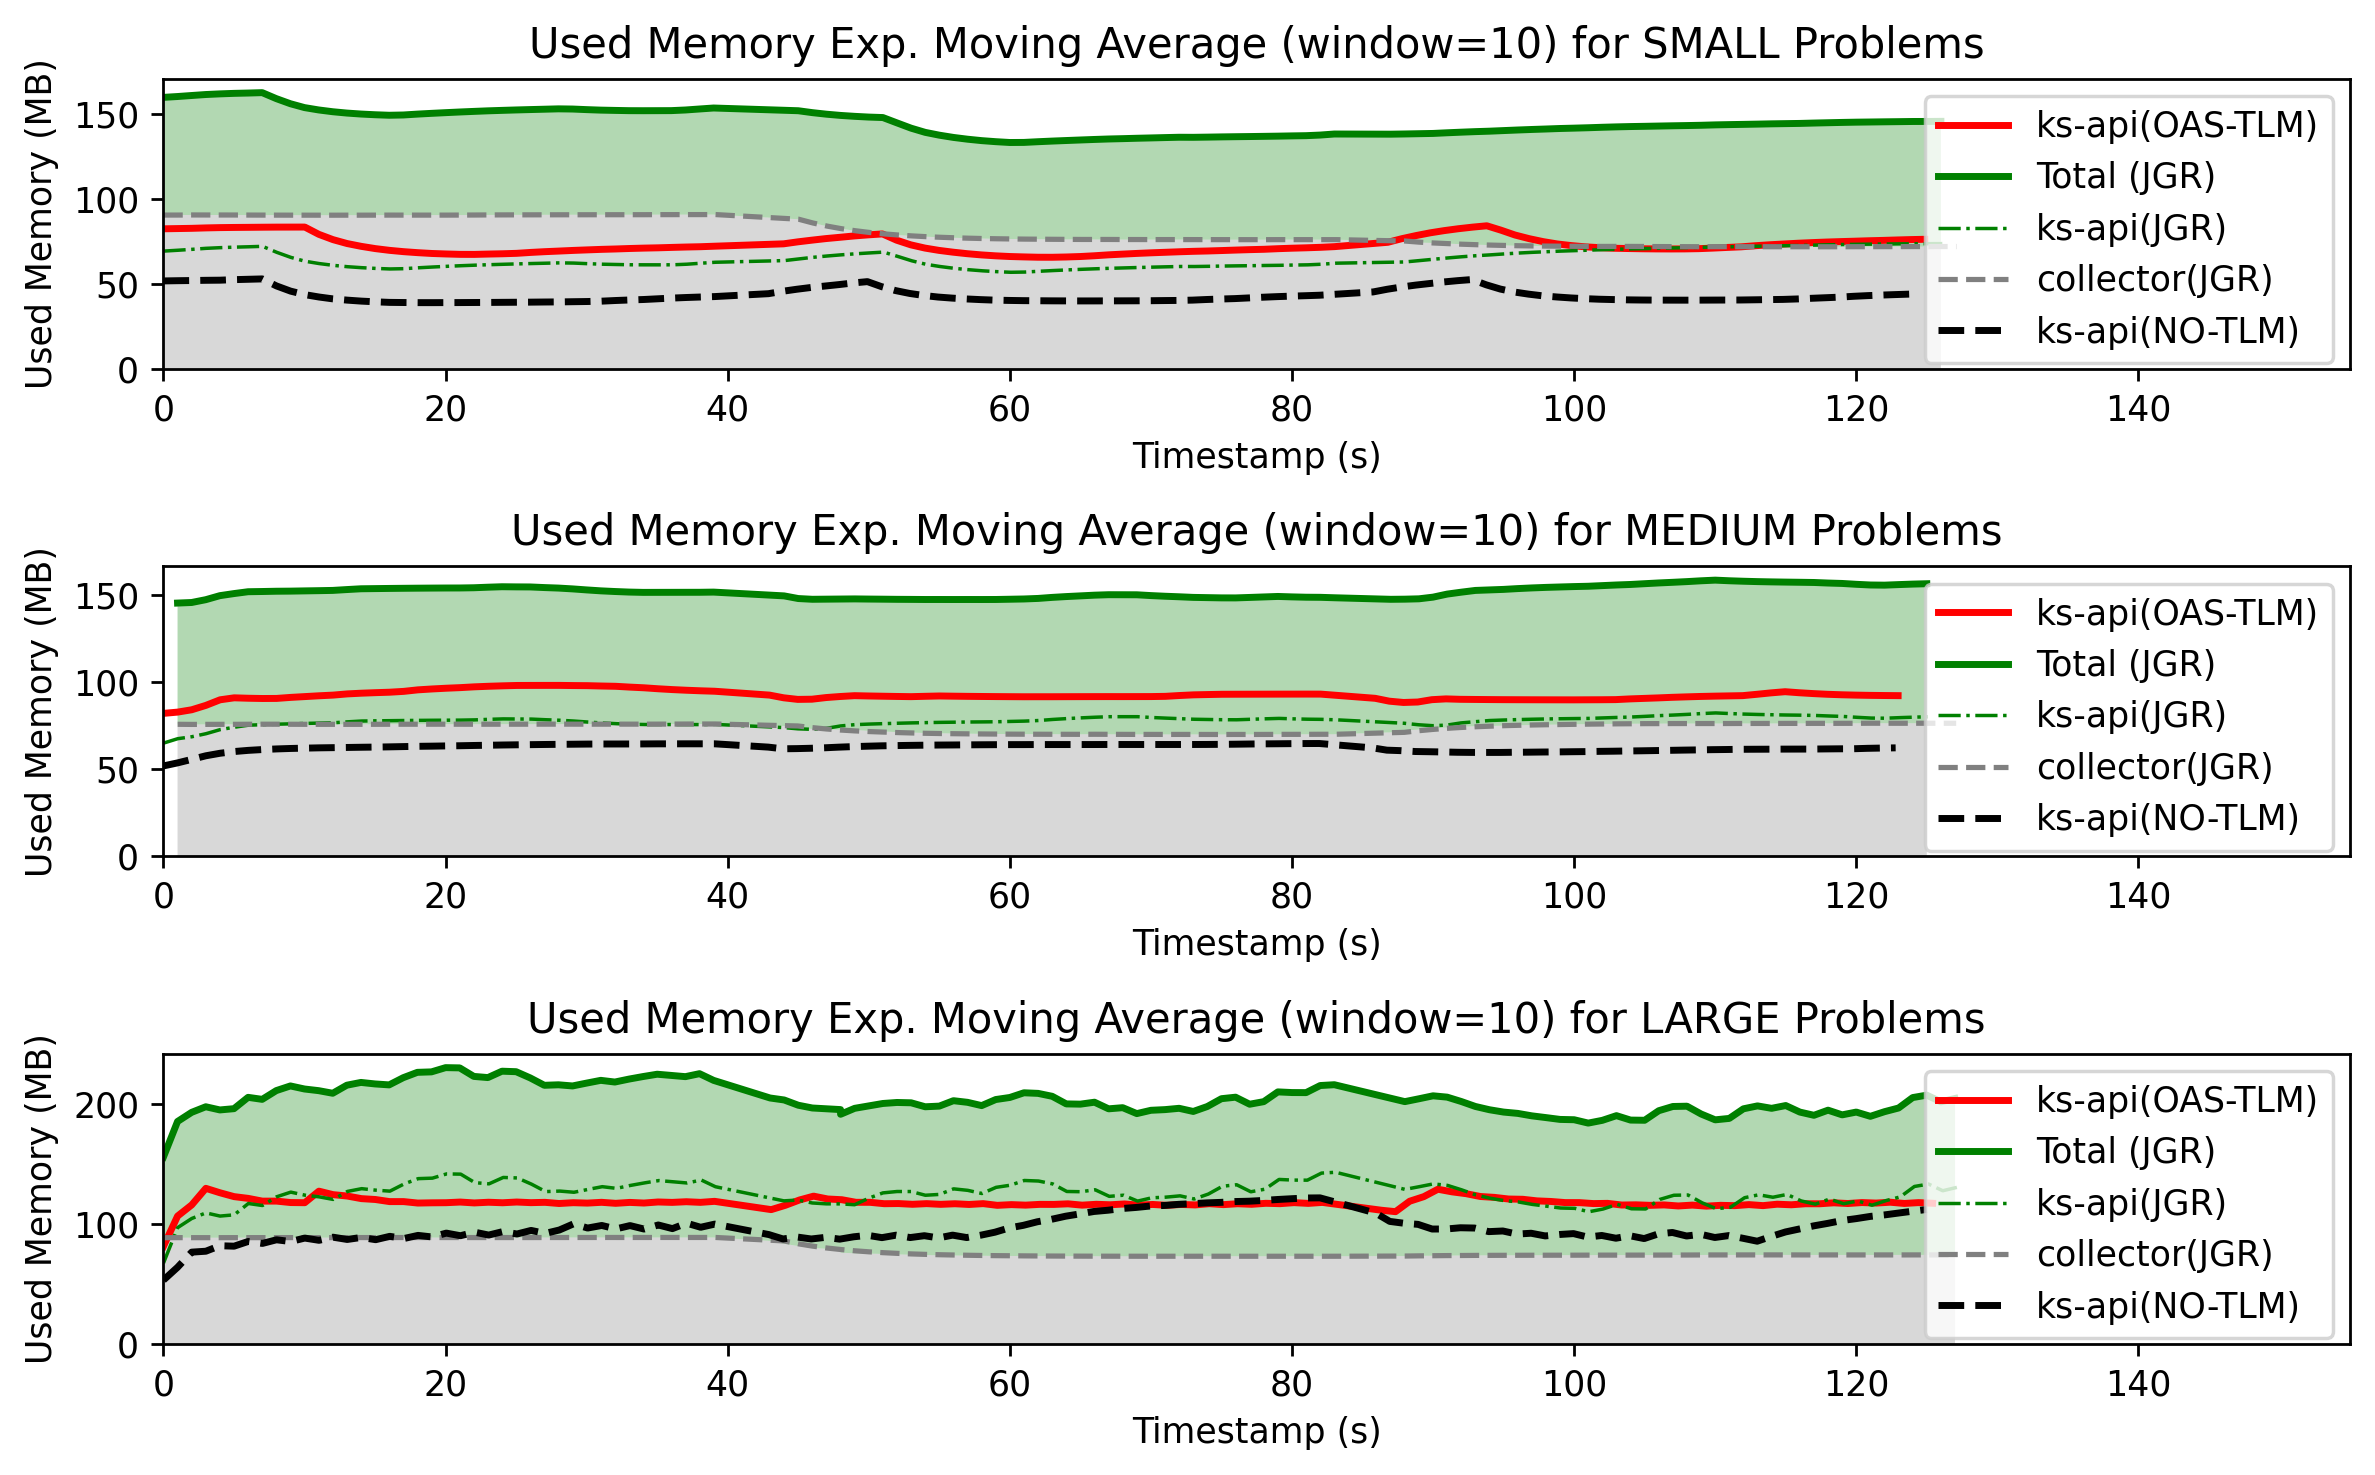

In [17]:
import matplotlib.pyplot as plt


# Plot the three graphs vertically by orderOfMagnitude.name

window = 10
size = 6
order_of_magnitude_names = ['small', 'medium', 'large']
fig, axes = plt.subplots(len(order_of_magnitude_names), 1, figsize=(size*1.6, size), dpi=250)


for i, name in enumerate(order_of_magnitude_names):
    group = docker_stats[docker_stats['orderOfMagnitude.name'] == name]

    # Create the variables
    samplesInOrderOfMagnitude = group
    tlm = samplesInOrderOfMagnitude[samplesInOrderOfMagnitude['index'] == 'OAS_TLM']
    
    no_tlm = samplesInOrderOfMagnitude[samplesInOrderOfMagnitude['index'] == 'NO_TLM']
    jaeger_api = samplesInOrderOfMagnitude[(samplesInOrderOfMagnitude['index'] == 'JAEGER') & (samplesInOrderOfMagnitude['containerName'] == 'oastlm-test-ks-api')]
    jaeger_container = samplesInOrderOfMagnitude[(samplesInOrderOfMagnitude['index'] == 'JAEGER') & (samplesInOrderOfMagnitude['containerName'] == 'jaeger')]

    # min size of the dataframes to all have the same size
    min_size = min(len(tlm), len(no_tlm), len(jaeger_api), len(jaeger_container))
    tlm = tlm.head(min_size)
    no_tlm = no_tlm.head(min_size)
    jaeger_api = jaeger_api.head(min_size)
    jaeger_container = jaeger_container.head(min_size)
    
    #moving average of used_memory per dataframe
    tlm['used_memory_moving_average'] = tlm['used_memory'].ewm(span=window).mean()
    no_tlm['used_memory_moving_average'] = no_tlm['used_memory'].ewm(span=window).mean()
    jaeger_api['used_memory_moving_average'] = jaeger_api['used_memory'].ewm(span=window).mean()
    jaeger_container['used_memory_moving_average'] = jaeger_container['used_memory'].ewm(span=window).mean()
    
    # api and container have different timestamps to stackplot we need a common index, so we will use seconds new column, (timestampsecond to int)
    jaeger_api['testSecond'] = jaeger_api['timestampSecond'].astype(int)
    jaeger_container['testSecond'] = jaeger_container['timestampSecond'].astype(int)

    # modify the index to be the same for both dataframes
    jaeger_merged = pd.merge(jaeger_api, jaeger_container, on='testSecond', how='inner')
    jaeger_merged['used_memory_moving_average_api'] = jaeger_merged['used_memory_x'].ewm(span=window).mean()
    jaeger_merged['used_memory_moving_average_container'] = jaeger_merged['used_memory_y'].ewm(span=window).mean()


    ax = axes[i]

    # OAS TELEMTRY
    ax.plot(tlm['timestampSecond'], tlm['used_memory_moving_average'], color='red', linewidth=2, label='ks-api(OAS-TLM)')
    
    # JAEGER TOTAL
    total_jaeger_memory = jaeger_merged['used_memory_moving_average_container'] + jaeger_merged['used_memory_moving_average_api']
    ax.plot(jaeger_merged['testSecond'], total_jaeger_memory, color='green', linestyle='-', linewidth=2, label='Total (JGR)')
    
    # JAEGER (CONTAINER AND API)
    ax.plot(jaeger_api['timestampSecond'], jaeger_api['used_memory_moving_average'], color='green', linestyle='-.', linewidth=1, label='ks-api(JGR)')
    ax.plot(jaeger_container['timestampSecond'], jaeger_container['used_memory_moving_average'], color='gray', linestyle='--', label='collector(JGR)')
    
    # stackplot of jaeger container and jaeger api
    ax.stackplot(jaeger_merged['testSecond'], jaeger_merged['used_memory_moving_average_container'], jaeger_merged['used_memory_moving_average_api'], colors=['gray', 'green'], alpha=0.3)
    ax.plot(no_tlm['timestampSecond'], no_tlm['used_memory_moving_average'], color='black', linestyle='dashed', linewidth=2, label='ks-api(NO-TLM)')
    
    ax.set_title(f'Used Memory Exp. Moving Average (window={window}) for {name.upper()} Problems')
    ax.set_xlabel('Timestamp (s)')
    ax.set_ylabel('Used Memory (MB)')
    ax.legend()
    ax.set_xlim(0, 155)
plt.tight_layout()
plt.show()


fig.savefig('plots/jaeger_Test1_UsedMemory_AllOrders_timeline.png')


In [18]:
#print some statistics, min, max, mean, std,
def get_stats(data, columnTarget, groupByColumns):
    result = data.groupby(groupByColumns)[columnTarget].agg(['min', 'max', 'mean', 'std']).reset_index()
    return result
docker_stats_copy = docker_stats.copy()[['orderOfMagnitude.name', 'index', 'containerName', 'used_memory']]

mem_stats = get_stats(docker_stats_copy, 'used_memory', ['orderOfMagnitude.name', 'index', 'containerName'])
jaeger_stats = mem_stats[mem_stats['index'] == 'JAEGER']

total_sums = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['mean'].sum().reset_index()
total_sums['min'] = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['min'].min().reset_index()['min']
total_sums['max'] = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['max'].max().reset_index()['max']

total_sums['containerName'] = 'total'


mem_stats2 = pd.concat([mem_stats, total_sums], ignore_index=True)

def calculate_relative_change(df, target_column):
    for name in df['orderOfMagnitude.name'].unique():
        no_tlm_mean = df[(df['orderOfMagnitude.name'] == name) & (df['index'] == 'NO_TLM')][target_column].values[0]
        df.loc[df['orderOfMagnitude.name'] == name, 'rel_change_%'] = (df[target_column] - no_tlm_mean) / no_tlm_mean * 100
    return df

mem_stats2 = calculate_relative_change(mem_stats2, 'mean')

# set the display options


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.4f}'.format)
#
display(mem_stats2)


,orderOfMagnitude.name,index,containerName,min,max,mean,std,rel_change_%
0,large,JAEGER,jaeger,72.7859,88.7562,78.5169,7.1693,-19.4213
1,large,JAEGER,oastlm-test-ks-api,64.5530,173.6049,125.5704,21.4334,28.8678
2,large,NO_TLM,oastlm-test-ks-api,51.7243,124.2767,97.4412,17.3810,0.0000
3,large,OAS_TLM,oastlm-test-ks-api,80.7772,165.7651,117.7269,11.0479,20.8183
4,medium,JAEGER,jaeger,69.5214,76.4846,73.9558,2.9143,18.3770
5,medium,JAEGER,oastlm-test-ks-api,64.8888,83.9148,77.9641,3.3079,24.7929
6,medium,NO_TLM,oastlm-test-ks-api,50.8518,64.9011,62.4748,2.6330,0.0000
7,medium,OAS_TLM,oastlm-test-ks-api,79.7614,99.2625,92.4504,3.7260,47.9802
8,small,JAEGER,jaeger,71.7169,91.0377,79.6099,8.1250,85.3046
9,small,JAEGER,oastlm-test-ks-api,51.9619,74.0598,65.2796,6.4708,51.9486


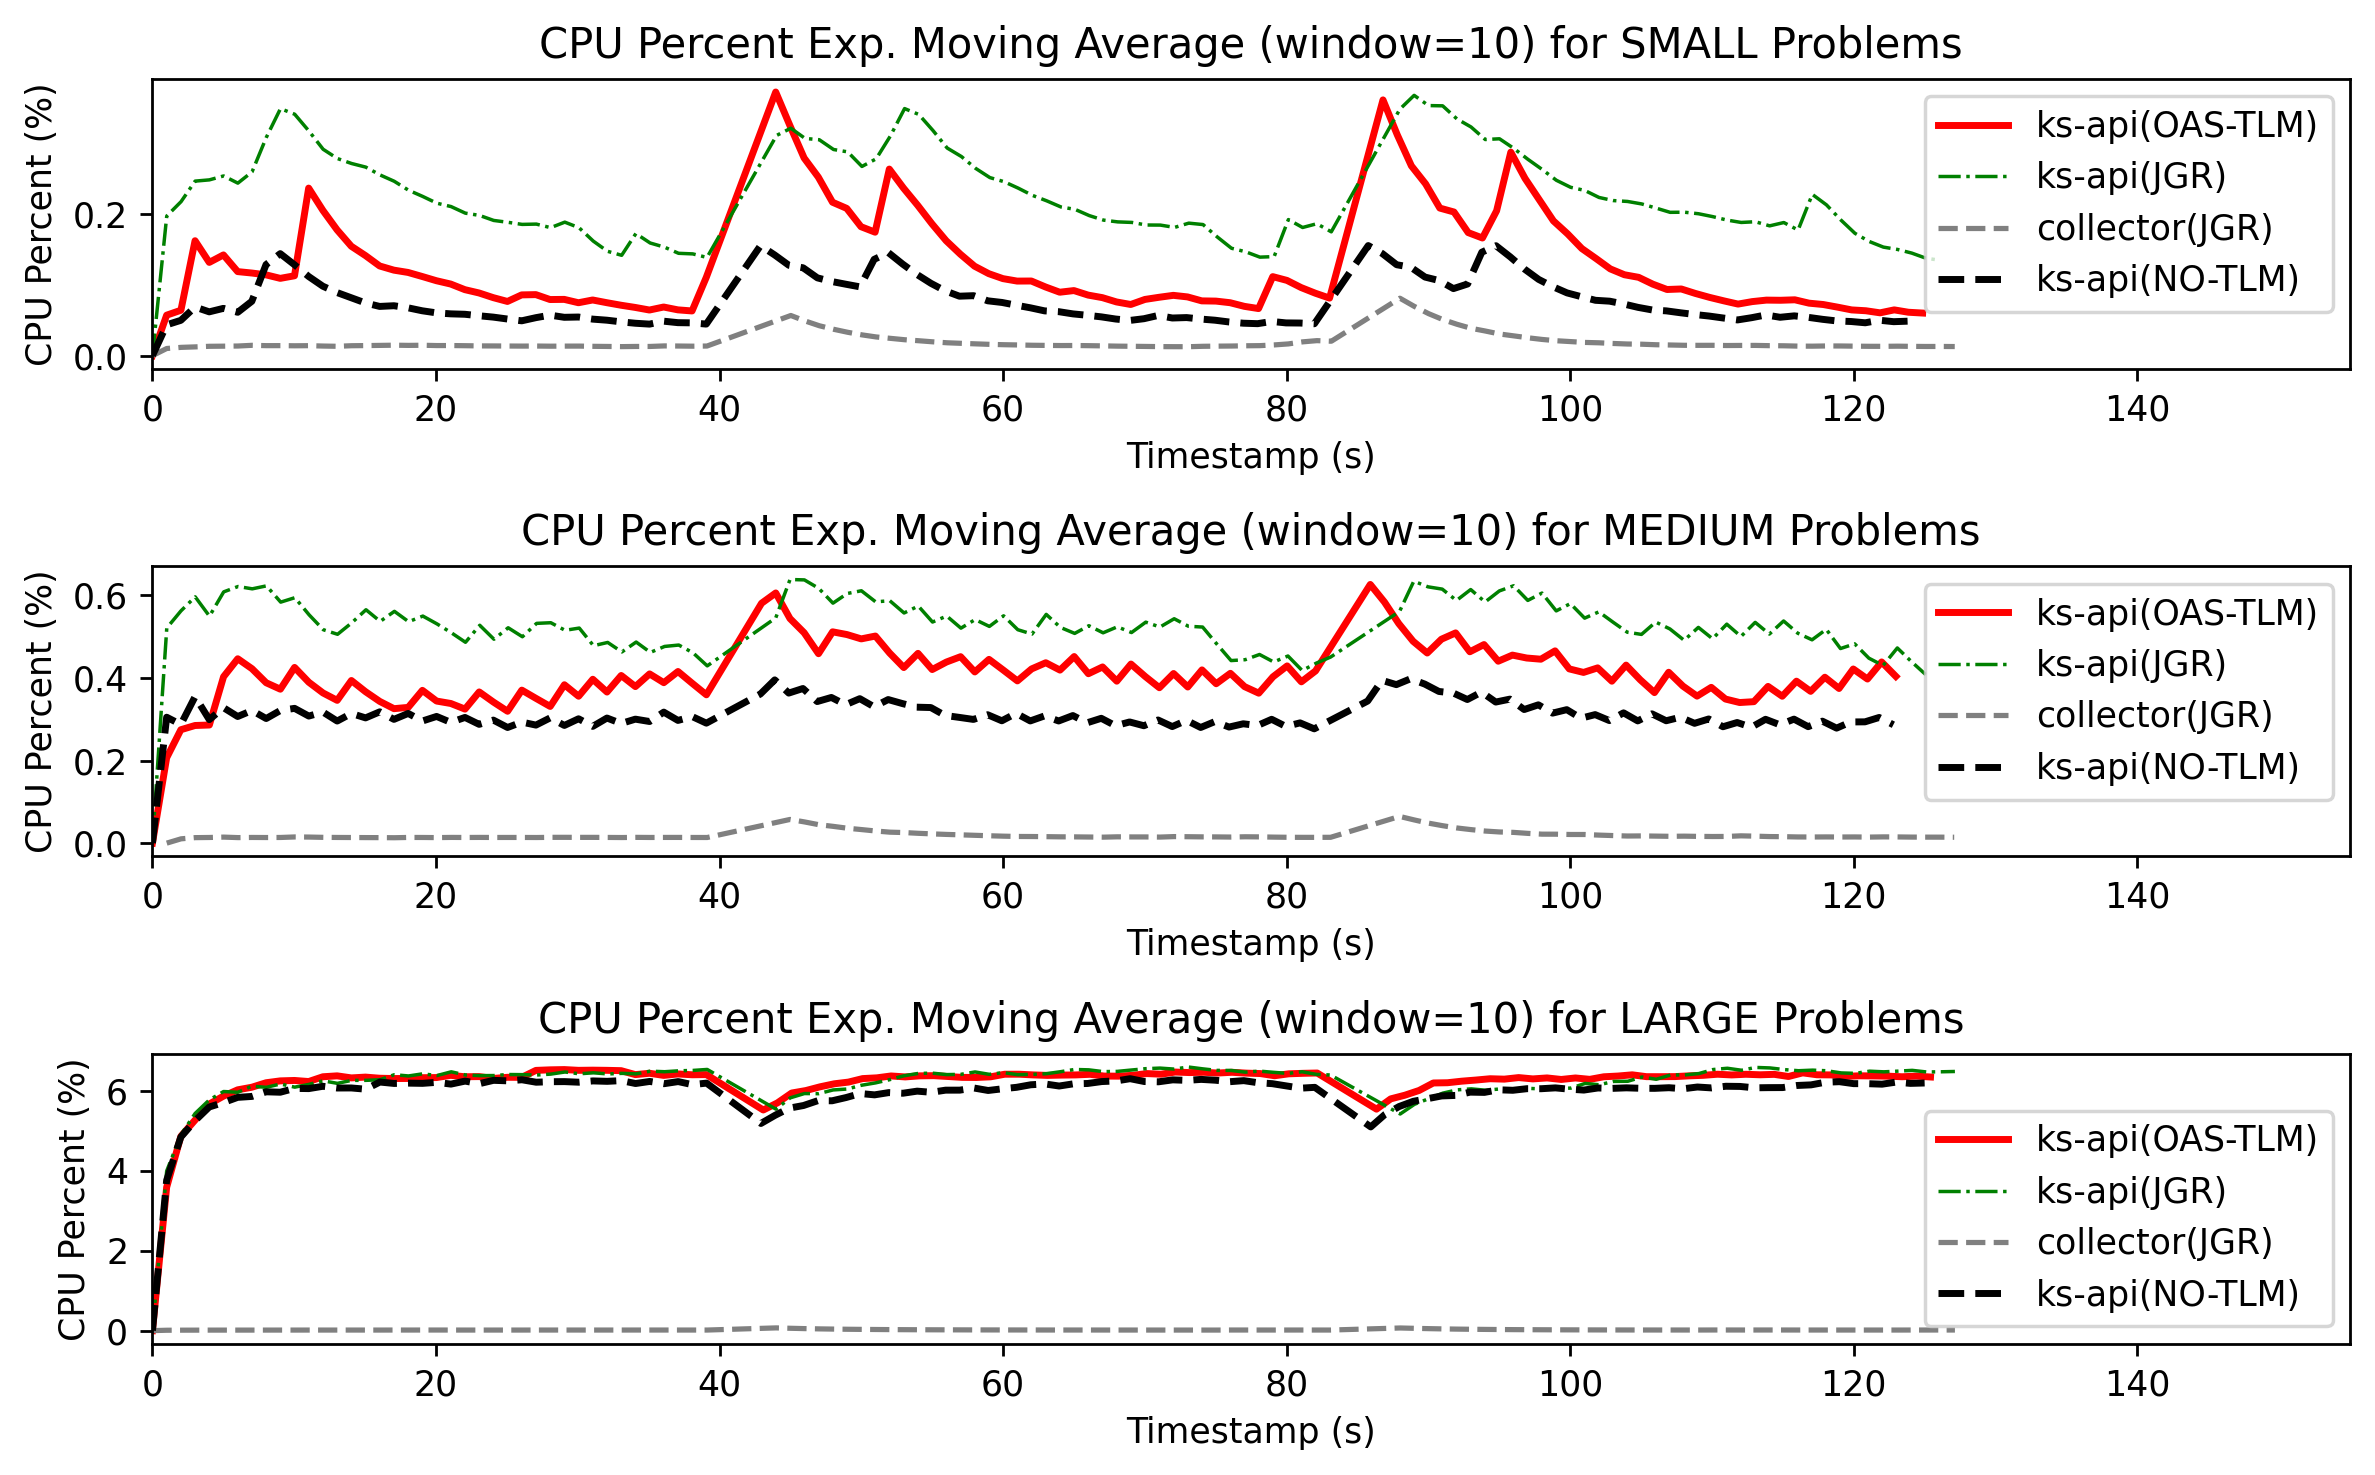

In [26]:
import matplotlib.pyplot as plt

# Plot the three graphs vertically by orderOfMagnitude.name

window = 10
size = 6
order_of_magnitude_names = ['small', 'medium', 'large']
fig, axes = plt.subplots(len(order_of_magnitude_names), 1, figsize=(size*1.6, size), dpi=250)

for i, name in enumerate(order_of_magnitude_names):
    group = docker_stats[docker_stats['orderOfMagnitude.name'] == name]

    # Create the variables
    samplesInOrderOfMagnitude = group
    tlm = samplesInOrderOfMagnitude[samplesInOrderOfMagnitude['index'] == 'OAS_TLM']
    
    no_tlm = samplesInOrderOfMagnitude[samplesInOrderOfMagnitude['index'] == 'NO_TLM']
    jaeger_api = samplesInOrderOfMagnitude[(samplesInOrderOfMagnitude['index'] == 'JAEGER') & (samplesInOrderOfMagnitude['containerName'] == 'oastlm-test-ks-api')]
    jaeger_container = samplesInOrderOfMagnitude[(samplesInOrderOfMagnitude['index'] == 'JAEGER') & (samplesInOrderOfMagnitude['containerName'] == 'jaeger')]

    # min size of the dataframes to all have the same size
    min_size = min(len(tlm), len(no_tlm), len(jaeger_api), len(jaeger_container))
    tlm = tlm.head(min_size)
    no_tlm = no_tlm.head(min_size)
    jaeger_api = jaeger_api.head(min_size)
    jaeger_container = jaeger_container.head(min_size)
    
    # moving average of cpu_percent per dataframe
    tlm['cpu_percent_moving_average'] = tlm['cpu_percent'].ewm(span=window).mean()
    no_tlm['cpu_percent_moving_average'] = no_tlm['cpu_percent'].ewm(span=window).mean()
    jaeger_api['cpu_percent_moving_average'] = jaeger_api['cpu_percent'].ewm(span=window).mean()
    jaeger_container['cpu_percent_moving_average'] = jaeger_container['cpu_percent'].ewm(span=window).mean()
    
    # api and container have different timestamps to stackplot we need a common index, so we will use seconds new column, (timestampsecond to int)
    jaeger_api['testSecond'] = jaeger_api['timestampSecond'].astype(int)
    jaeger_container['testSecond'] = jaeger_container['timestampSecond'].astype(int)

    # modify the index to be the same for both dataframes
    jaeger_merged = pd.merge(jaeger_api, jaeger_container, on='testSecond', how='inner')
    jaeger_merged['cpu_percent_moving_average_api'] = jaeger_merged['cpu_percent_x'].ewm(span=window).mean()
    jaeger_merged['cpu_percent_moving_average_container'] = jaeger_merged['cpu_percent_y'].ewm(span=window).mean()

    # print name, min, max, mean, std for tlm, no_tlm, jaeger_api, jaeger_container, jaeger_merged

    ax = axes[i]

    # OAS TELEMETRY
    ax.plot(tlm['timestampSecond'], tlm['cpu_percent_moving_average'], color='red', linewidth=2, label='ks-api(OAS-TLM)')
    
    # JAEGER TOTAL
    total_jaeger_cpu = jaeger_merged['cpu_percent_moving_average_container'] + jaeger_merged['cpu_percent_moving_average_api']
    # ax.plot(jaeger_merged['testSecond'], total_jaeger_cpu, color='green', linestyle='-', linewidth=2, label='JGR Total')
    
    # JAEGER (CONTAINER AND API)
    ax.plot(jaeger_api['timestampSecond'], jaeger_api['cpu_percent_moving_average'], color='green', linestyle='-.', linewidth=1, label='ks-api(JGR)')
    ax.plot(jaeger_container['timestampSecond'], jaeger_container['cpu_percent_moving_average'], color='gray', linestyle='--', label='collector(JGR)')
    
    # # stackplot of jaeger container and jaeger api
    # ax.stackplot(jaeger_merged['testSecond'], jaeger_merged['cpu_percent_moving_average_container'], jaeger_merged['cpu_percent_moving_average_api'], colors=['gray', 'green'], alpha=0.3)
    ax.plot(no_tlm['timestampSecond'], no_tlm['cpu_percent_moving_average'], color='black', linestyle='dashed', linewidth=2, label='ks-api(NO-TLM)')
    
    ax.set_title(f'CPU Percent Exp. Moving Average (window={window}) for {name.upper()} Problems')
    ax.set_xlabel('Timestamp (s)')
    ax.set_ylabel('CPU Percent (%)')
    ax.legend()
    ax.set_xlim(0, 155)
plt.tight_layout()
plt.show()

# fig.savefig('plots/jaeger_Test1_CPUPercent_AllOrders_timeline.png')


In [20]:
#print some statistics, min, max, mean, std,
def get_stats(data, columnTarget, groupByColumns):
    result = data.groupby(groupByColumns)[columnTarget].agg(['min', 'max', 'mean', 'std']).reset_index()
    return result
docker_stats_copy = docker_stats.copy()[['orderOfMagnitude.name', 'index', 'containerName', 'cpu_percent']]

mem_stats = get_stats(docker_stats_copy, 'cpu_percent', ['orderOfMagnitude.name', 'index', 'containerName'])
jaeger_stats = mem_stats[mem_stats['index'] == 'JAEGER']

total_sums = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['mean'].sum().reset_index()
total_sums['min'] = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['min'].min().reset_index()['min']
total_sums['max'] = jaeger_stats.groupby(['orderOfMagnitude.name', 'index'])['max'].max().reset_index()['max']

total_sums['containerName'] = 'total'


mem_stats2 = pd.concat([mem_stats, total_sums], ignore_index=True)

def calculate_relative_change(df, target_column):
    for name in df['orderOfMagnitude.name'].unique():
        no_tlm_mean = df[(df['orderOfMagnitude.name'] == name) & (df['index'] == 'NO_TLM')][target_column].values[0]
        df.loc[df['orderOfMagnitude.name'] == name, 'delta'] = (df[target_column] - no_tlm_mean) 
        df.loc[df['orderOfMagnitude.name'] == name, 'rel_change_%'] = (df[target_column] - no_tlm_mean) / no_tlm_mean * 100
    return df

mem_stats2 = calculate_relative_change(mem_stats2, 'mean')

# set the display options


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.10f}'.format)
print('CPU Percent Statistics')
display(mem_stats2)

CPU Percent Statistics


,orderOfMagnitude.name,index,containerName,min,max,mean,std,delta,rel_change_%
0,large,JAEGER,jaeger,0.0000162754,0.3101898750,0.0192814509,0.0372679165,-6.0253661971,-99.6810161315
1,large,JAEGER,oastlm-test-ks-api,0.0000572386,7.2659203762,6.3107932494,0.9440877117,0.2661456014,4.4029961193
2,large,NO_TLM,oastlm-test-ks-api,0.0000277932,6.9984984462,6.0446476480,0.9343093158,0.0000000000,0.0000000000
3,large,OAS_TLM,oastlm-test-ks-api,0.0000768327,7.2980030788,6.2959469633,0.8827328768,0.2512993153,4.1573856723
4,medium,JAEGER,jaeger,0.0000173223,0.2922772786,0.0191020596,0.0337271396,-0.2906792811,-93.8336958654
5,medium,JAEGER,oastlm-test-ks-api,0.0000577214,1.0681880408,0.5215175683,0.1755099437,0.2117362275,68.3502198726
6,medium,NO_TLM,oastlm-test-ks-api,0.0000272919,0.6785846609,0.3097813408,0.1033331646,0.0000000000,0.0000000000
7,medium,OAS_TLM,oastlm-test-ks-api,0.0000705329,1.5782279435,0.4112349993,0.2202592370,0.1014536585,32.7500869753
8,small,JAEGER,jaeger,0.0000185475,0.3535435567,0.0187751861,0.0378935671,-0.0559758810,-74.8830527095
9,small,JAEGER,oastlm-test-ks-api,0.0000555152,1.1245744297,0.2206471840,0.1475705474,0.1458961168,195.1759652901


In [21]:
# Now response times:
import pandas as pd

response_times = pd.read_csv('jaeger-response-times-v4.csv')

response_times = response_times[response_times['timestamp'] != 'timestamp']

response_times['timestamp'] = pd.to_datetime(response_times['timestamp'])

# Map index values

response_times['index'] = response_times['index'].map({'Jaeger': 'JAEGER', 'Telemetry': 'OAS_TLM', '': 'NO_TLM'}).fillna("NO_TLM")



response_times['timestampSecond'] = response_times.groupby(['index', 'testname', 'orderOfMagnitude.name'])['timestamp'].transform(lambda x: (x - x.iloc[0]).dt.total_seconds().astype(float))

response_times = response_times.apply(pd.to_numeric, errors='ignore')



response_times.head()

,timestamp,responseTime,testname,repeatTestCount,index,orderOfMagnitude.name,orderOfMagnitude.value,orderOfMagnitude.estimatedResponseTime,orderOfMagnitude.secureResponseTime,baseURL,concurrentUsers,currentIteration,telemetryStatus,requests,url,delay,total_heap_size_before,total_heap_size_executable_before,used_heap_size_before,heap_size_limit_before,malloced_memory_before,total_heap_size_after,total_heap_size_executable_after,used_heap_size_after,heap_size_limit_after,malloced_memory_after,timestampSecond
0,1734814107383000000,6.6010000000,Jaeger Comparison,3,OAS_TLM,small,2,1,200,http://localhost:8080,1,1,UNKNOWN,200,http://localhost:8080/api/v1/stress/2/2,200,56.9060000000,1.7500000000,42.5750000000,1048,1.5310000000,56.4060000000,2.2500000000,37.0770000000,1048,1.0310000000,0.0000000000
1,1734814107585000000,3.5480000000,Jaeger Comparison,3,OAS_TLM,small,2,1,200,http://localhost:8080,1,1,UNKNOWN,200,http://localhost:8080/api/v1/stress/2/2,200,56.9060000000,1.7500000000,42.5750000000,1048,1.5310000000,56.4060000000,2.2500000000,37.0770000000,1048,1.0310000000,0.2020000000
2,1734814107789000000,4.2130000000,Jaeger Comparison,3,OAS_TLM,small,2,1,200,http://localhost:8080,1,1,UNKNOWN,200,http://localhost:8080/api/v1/stress/2/2,200,56.9060000000,1.7500000000,42.5750000000,1048,1.5310000000,56.4060000000,2.2500000000,37.0770000000,1048,1.0310000000,0.4060000000
3,1734814107993000000,3.4240000000,Jaeger Comparison,3,OAS_TLM,small,2,1,200,http://localhost:8080,1,1,UNKNOWN,200,http://localhost:8080/api/v1/stress/2/2,200,56.9060000000,1.7500000000,42.5750000000,1048,1.5310000000,56.4060000000,2.2500000000,37.0770000000,1048,1.0310000000,0.6100000000
4,1734814108182000000,3.5570000000,Jaeger Comparison,3,OAS_TLM,small,2,1,200,http://localhost:8080,1,1,UNKNOWN,200,http://localhost:8080/api/v1/stress/2/2,200,56.9060000000,1.7500000000,42.5750000000,1048,1.5310000000,56.4060000000,2.2500000000,37.0770000000,1048,1.0310000000,0.7990000000


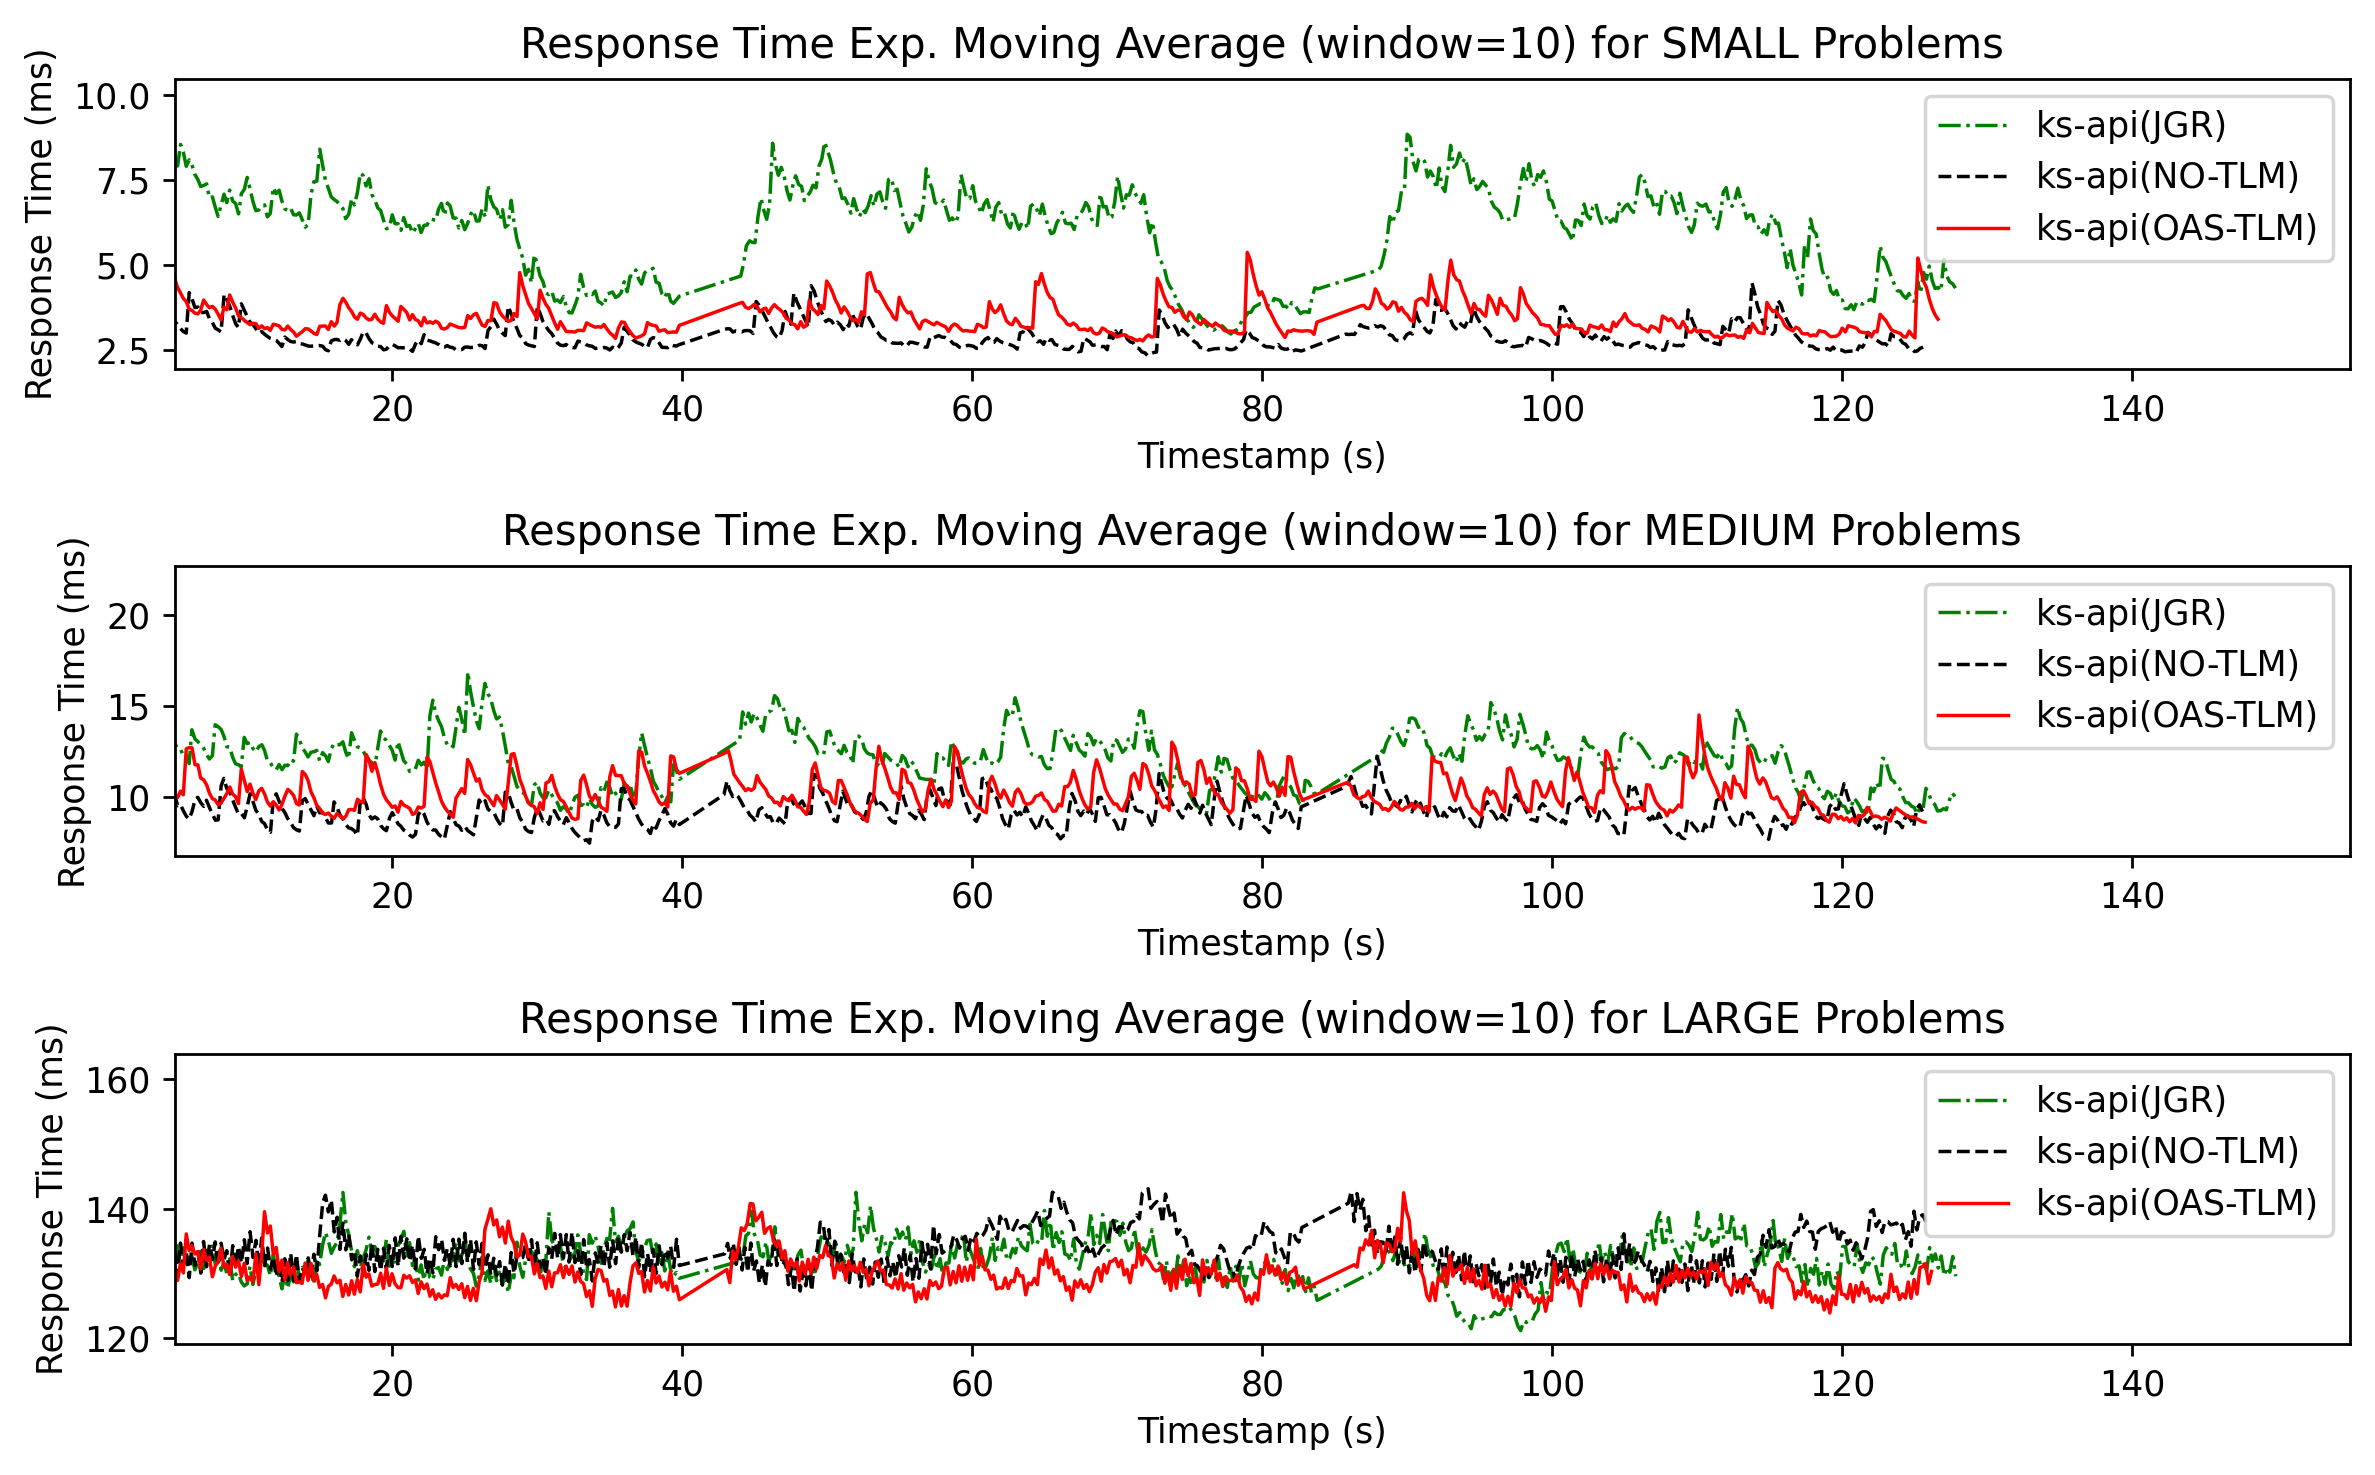

In [22]:
# Compare responseTime with moving average in a plot
import matplotlib.pyplot as plt

# Define the window size for the moving average
window_size = 10
order_of_magnitude_names = ['small', 'medium', 'large']
filtered_cases = ['NO_TLM', 'OAS_TLM', 'JAEGER']
size = 6
fig, axes = plt.subplots(len(order_of_magnitude_names), 1, figsize=(size*1.6, size), dpi=250)

for i, name in enumerate(order_of_magnitude_names):
    ax = axes[i] if len(order_of_magnitude_names) > 1 else axes
    for key, grp in response_times[(response_times['orderOfMagnitude.name'] == name) & (response_times['index'].isin(filtered_cases))].groupby(['index', 'testname']):
        grp['responseTime_ewm'] = grp['responseTime'].ewm(span=window_size).mean()
        
        if key[0] == 'NO_TLM':
            color = 'black'
            label = 'ks-api(NO-TLM)'
            linestyle = 'dashed'
            linewidth = 1
        elif key[0] == 'OAS_TLM':
            color = 'red'
            label = 'ks-api(OAS-TLM)'
            linestyle = 'solid'
            linewidth = 1
        elif key[0] == 'JAEGER':
            color = 'green'
            label = 'ks-api(JGR)'
            linestyle = '-.'
            linewidth = 1
        
        grp.plot(ax=ax, kind='line', x='timestampSecond', y='responseTime_ewm', label=label, color=color, linestyle=linestyle, linewidth=linewidth, title=name)

    
    ax.set_title(f'Response Time Exp. Moving Average (window={window_size}) for {name.upper()} Problems')
    ax.set_xlabel('Timestamp (s)')
    ax.set_ylabel('Response Time (ms)')
    #x>5
    ax.set_xlim(5,155)
    

plt.tight_layout()
plt.show()
fig.savefig('plots/jaeger_Test1_ResponseTime_AllOrders_timeline.png')



In [23]:
#print some statistics, min, max, mean, std,
def get_stats(data, columnTarget, groupByColumns):
    result = data.groupby(groupByColumns)[columnTarget].agg(['min', 'max', 'mean', 'std']).reset_index()
    return result


rt_stats =get_stats(response_times, 'responseTime', ['orderOfMagnitude.name', 'index'])
def calculate_relative_change(df, target_column):
    for name in df['orderOfMagnitude.name'].unique():
        no_tlm_mean = df[(df['orderOfMagnitude.name'] == name) & (df['index'] == 'NO_TLM')][target_column].values[0]
        df.loc[df['orderOfMagnitude.name'] == name, 'rel_change_%'] = (df[target_column] - no_tlm_mean) / no_tlm_mean * 100
    return df

rt_stats = calculate_relative_change(rt_stats, 'mean')
display(rt_stats)

,orderOfMagnitude.name,index,min,max,mean,std,rel_change_%
0,large,JAEGER,109.6100000000,182.1640000000,132.1748866667,11.9270876665,-0.9769075653
1,large,NO_TLM,104.7330000000,168.0450000000,133.4788516667,15.3036214922,0.0000000000
2,large,OAS_TLM,106.7160000000,176.3580000000,129.8477066667,10.9592668823,-2.7203897506
3,medium,JAEGER,7.0380000000,32.5340000000,12.1574200000,3.3397455223,32.6738489929
4,medium,NO_TLM,6.1120000000,22.2200000000,9.1633883333,2.6510006296,0.0000000000
5,medium,OAS_TLM,7.0680000000,29.9060000000,10.2330766667,3.4759828157,11.6735021416
6,small,JAEGER,2.4510000000,16.6820000000,6.0902483333,2.2301300493,107.4601419119
7,small,NO_TLM,1.9070000000,11.0430000000,2.9356233333,1.1577837839,0.0000000000
8,small,OAS_TLM,2.2730000000,15.8920000000,3.4743083333,1.4675104786,18.3499359023
